# Pràctica 1: Resolem un problema de classificacio

## Objectius

Els objectius d'aquesta pràctica són:

* Aplicar els coneixements adquirits sobre classificacio, tecniques d'emplenats de nans i validacio creuada.
  
* Ser capac de comparar diferents models classificacio

* Ser capac de fer busca d'hiperparametres.

* Entendre i implamentar la validacio creuada

* Analitzar detalladament els resultats obtinguts durant l'aprenentatge dels diferents models.

Aquesta practica es previa al cas kaggle que realitzareu durant la segona part de l'assignatura. En aquesta primera practica les preguntes estan definides, pero us ha de servir d'aprenentatge alhora de saber com estructurar un projecte d'aprenentatge automatic ja que en el cas kaggle no tindreu les preguntes.

## Bases de dades

En aquesta practica farem servir la base de dades del titanic. L'atribut que predirem es Survived, el qual ens diu si va sobreviure o no cada passatger.


https://www.kaggle.com/c/titanic/data


##Treball en grup
Aquesta practica es treballara en grups de 2-3 persones. En casos excepcionals i degudament justificats la practica es podra realitzar de forma individual.
## Seguiment i entrega de la pràctica

En la pràctica 1, es presenten diverses tasques per fer una correcta comparativa dels resultats obtinguts per diversos mètodes de classificació numèrica en una mateixa base de dades.


En aquesta practica es realitzara sessions de seguiment del treball. Aquestes sessions de treball està orientada a que els alumnes que vingueu pugueu preguntar i resoldre dubtes sobre les dades, preguntar sobre l'objectiu de cada apartat dels enunciats que no us hagi quedat clar, i preguntar sobre els resultats que esteu obtenint a l'hora d'analitzar les dades. Es molt recomanable venir amb el treball fet a clase per tal de poder comentar dubtes.

Pel que fa l'entrega, caldra entregar per caronte el seguent:

1. Memòria en format PDF o en la mateixa notebook explicant els resultats trobats sobre la bases de dades amb el respectiu codi de python. Aquesta nota es la mateixa per tots els membres del grup (8 pts)

2. Presentació amb els resultats 4 min màxim. Aquesta nota es individual. (2 pt)

Nota: En cas d'entregar la memoria com a PDF, caldra entregar el codi de python a part. Si s'entrega com a notebook, la mateixa notebook servira com a codi.



# Descripcio de la pràctica

A continuacio es mostren tots els continguts que s'evaluara en la pràctica:

1. EDA (exploratory data analysis) (1 punts):
  * Analisi de tamany i tipologia de dades ( 0.25 pt)
  * Primera valoracio de correlacions ( 0.5 pt)
  * Analisi atribut target ( 0.25 pt)
2. Preprocessing (2 punts):
  * Eliminacio de nans (0.5 punts)
  * Encoding de categoriques (0.75 punts)
  * Altres (PCA, normalitzacio..)
3. Metric selection (1.5 punts):
  * Seleccio de la millor metrica pel problema (0.75 punts)
  * Visualitzacio de ROC/AUC (0.75 punts)
4. Model Selection amb Crossvalidation (4 punts):
  * Seleccio del millor model (2 punts)
  * Busqueda hiperparametres (2 punts)
5. Analisi final (1.5 punt)

Cal dir que, les puntuacions dins de cada apartat son orientatives. La pràctica esta construida a partir d'un seguit de preguntes orientatives en cada apartat les quals tenen relacio amb els continguts evaluables. **NO cal contestar-les totes**. Són una guia per a que reflexioneu i aprengueu detalls de cada apartat.  Es recomanable, aixo si, llegir totes les preguntes abans de realitzar la practica i tenir-les en ment alhora d'executar-la.


**IMPORTANT**: El que es valorara en la practica es la capacitat de mantenir una narrativa coherent alhora que es realitzen els resultats. No es mirara tant que alguna pregunta quedi per respondre sino que els passos seguits en base als resultats obtinguts siguin coherents.

In [336]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import time

### 1. EDA (exploratory data analysis) (1 punt)

Abans de resm cal sempre veure com es la base de dades asignada?

**Preguntes:**
* Quants atributs té la vostra base de dades?
* Quin tipus d'atributs tens? (Númerics, temporals, categorics, binaris...)
* Com es el target, quantes categories diferents existeixen?
* Tenim nans en les dades?
* Podeu veure alguna correlació entre X i y?
* Estan balancejades les etiquetes (distribució similar entre categories)? Creus que pot afectar a la classificació la seva distribució?


Treballem sobre una base de dades que prediu la superviviencia en el Titanic.

El target, Survived, conté la categoria de que Sí sobreviu el passatger i la de que No sobreviu.

In [337]:
# Importem el fitxer
df_train = pd.read_csv('./titanic_data/train.csv')

ordenColumnasTrain = ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Survived']
df_train = df_train[ordenColumnasTrain]

print("Dimensió base de dades", df_train.shape)

# Comprovem si hi ha nans
def has_nans(df_train):
  return df_train.isna().sum().sum()>0

print ("Tenim nans?", has_nans(df_train))

Dimensió base de dades (891, 12)
Tenim nans? True


Es pot veure que treballem amb una base de dades que compta amb 812 files i 12 columnes. Aquestes columnes són de tipus string, integer o decimal. Dins d'aquestes dades, hi ha presència de valors buits.

In [338]:
# Mostrem els nans per fila
percent_nan_fila = df_train.isna().mean(axis = 1)
percent_nan_fila

0      0.083333
1      0.000000
2      0.083333
3      0.000000
4      0.083333
         ...   
886    0.083333
887    0.000000
888    0.166667
889    0.000000
890    0.083333
Length: 891, dtype: float64

In [339]:
# Mostrem el percentatge de nans per columna
def get_percentage_nan_per_column(df):
  return df_train.isna().sum().sort_values()/len(df_train)*100.

percentage_nan = get_percentage_nan_per_column(df_train)
percentage_nan

PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Survived        0.000000
Embarked        0.224467
Age            19.865320
Cabin          77.104377
dtype: float64

In [340]:
# Veiem quins atributs són strings
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
 11  Survived     891 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Considerem que les columnes de PassengerId, Name, Ticket i Cabin no són necessàries a l'hora de predir la supervivència i llavors les eliminem. Les columnes que principalment contenen nans són Cabin i Age. Eliminant la columna Cabin ens estalviem tractar el seu 77% de nans.

In [341]:
# Traiem atributs que no considerem necessaris
df_train.drop("PassengerId", axis='columns', inplace=True)
df_train.drop("Name", axis='columns', inplace=True)
df_train.drop("Ticket", axis='columns', inplace=True)
df_train.drop("Cabin", axis='columns', inplace=True)

# Contem el nombre de 0's i 1's
survived_count = df_train['Survived'].value_counts()
total_inst = len(df_train)

print(survived_count)
print(total_inst)

0    549
1    342
Name: Survived, dtype: int64
891


Com que després d'eliminar les columnes esmentades ja només ens queda el 19,86% de nans de la columna Age, considerem que no és necessari esborrar la columna sencera. Només esborrem aquelles files on hi hagi un nan a Age i a Embarked, pel que ara el dataset s'ha vist reduït a 712 files. Aquí aprofitem per veure que les dades no estan balancejades, ja que trobem 424 ceros i 288 uns. Encara que la diferencia sigui de aproximadament 150, si les dades augmentessin de mida el desbalanceig seria molt gran.

In [342]:
# Contem el nombre de 0's i 1's després de treure els nans
df_train = df_train.dropna()
#df_test = df_test.dropna()

survived_count = df_train['Survived'].value_counts()
total_inst = len(df_train)

print(survived_count)
print(total_inst)

0    424
1    288
Name: Survived, dtype: int64
712


Per mostrar la matriu de correlació cal que codifiquem els atributs de tipus object que ens interessen, que són Sex i Embarked.

In [343]:
# Codifiquem els atributs Sex i Embarked
Sex_train = df_train.copy()
restantes = []
for i in Sex_train.columns:
    if i != 'Sex':
        restantes.append(i)
Sex_train.drop(restantes, axis='columns', inplace=True)

codificar = OrdinalEncoder()
codificar.fit(Sex_train)
codificar.categories_
Sex_train = codificar.transform(Sex_train)
Sex_train = Sex_train.astype(np.int64)

df_train['Sex'] = Sex_train

Embarked_train = df_train.copy()
restantes = []
for i in Embarked_train.columns:
    if i != 'Embarked':
        restantes.append(i)
Embarked_train.drop(restantes, axis='columns', inplace=True)

codificar = OrdinalEncoder()
codificar.fit(Embarked_train)
codificar.categories_
Embarked_train = codificar.transform(Embarked_train)
Embarked_train = Embarked_train.astype(np.int64)

df_train['Embarked'] = Embarked_train

<ipython-input-343-5bea2803dddb>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Sex'] = Sex_train
<ipython-input-343-5bea2803dddb>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Embarked'] = Embarked_train


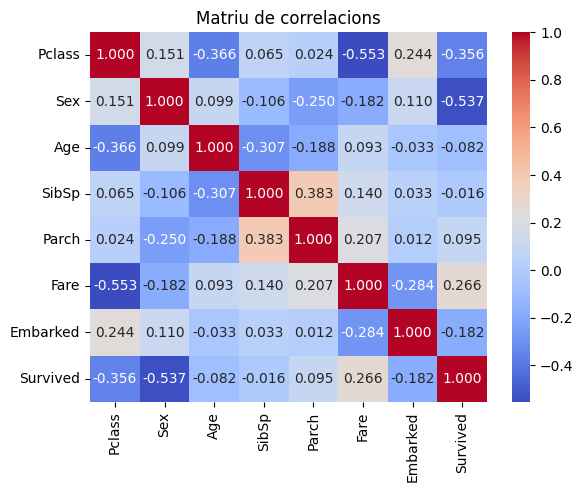

In [344]:
# Construïm la matriu de correlació un cop ja hem codificat els atributs que considerem importants

matriz_correlacion = df_train.corr()

sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Matriu de correlacions')
plt.show()

Es pot veure que els atributs que presenten una major correlació, negativa o positiva, amb el target, són Pclass (-0,356), Sex (-0,537), Fare (0,266) i Embarked (-0,182). La resta d'atributs tenen correlacions molt properes a 0.

### 2. Preprocessing (normalitzation, outlier removal, feature selection..) (2 punts)
Un cop vistes les dades de les que es disposa, cal preparar les dades per als nostres algoritmes. Segons la tipologia de dades, es poden filtrar atributs, aplicar-hi reductors de dimensionalitat, codificar categories textuals en valors numèrics, normalitzar les dades, treure outliers...

Navegueu per la [documentació de sklearn sobre preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html) per tal de trobar les diferents opcions que proporciona sklearn.

**Preguntes:**
* Estàn les dades normalitzades? Caldria fer-ho?
* En cas que les normalitzeu, quin tipus de normalització será més adient per les vostres dades?
* Teniu gaires dades sense informació (nans)? Tingueu en compte que hi ha metodes que no els toleren durant el aprenentatge. Com afecta a la classificació si les filtrem? I si les reompliu? Com ho farieu? [Pista](https://scikit-learn.org/stable/modules/impute.html)
* Teniu dades categoriques? Quina seria la codificació amb més sentit?
* Podreu treure algun atribut extra de les categoriques (per exemple, aplicant alguna regla sobre el text)?
* Caldria aplicar PCA? Quins beneficis o inconvenients trobarieu?
* Caldria aplicar alguna tecnica de seleccio de features? Ho trobeu necessari?
* Es poden aplicar PolynomialFeatures per millorar la classificació? En quins models té sentit fer-ho?

Un cop hem representat la matriu de correlacions, escollim aquells atributs amb una correlació més propera a -1 i 1. Escollim llavors Pclass, Sex, Fare i Embarked. A partir d'això generem un nou dataset que contingui únicament aquestes columnes i la del target. Amb aquest nou dataset ja fem la separació en X i y, on X són les variables independents i y el target, la dependent.

In [345]:
# Separem els atributs escollits del target, en X i y

df_train1 = df_train.copy()
restantes = []
for i in df_train1.columns:
    if i != 'Pclass' and i != 'Sex' and i != 'Fare' and i != 'Embarked' and i != 'Survived':
        restantes.append(i)
df_train1.drop(restantes, axis='columns', inplace=True)

data = df_train1.values
X = data[:, :-1]
y = data[:, -1]

Normalitzem les dades estandarditzant-les, que implica escalar els seus valors restant-los la seva mitjana i dividint-los per la seva desviació estàndard. Reescalar els valors no ho veiem adequat perquè llavors les dades prenen valors entre 0 i 1.

In [346]:
# Fem la normalització de les dades, estandarditzant
sc = StandardScaler()
X = sc.fit_transform(X)

Degut a que ja comptem amb un nombre bastant reduït de dades, no cal que apliquem PCA per veure la correlació entre les característiques perquè això ja ho hem vist amb la matriu. És justament mitjançant la matriu de correlació amb la que hem escollit quines característiques ens interesaven mantenir per poder classificar, pel que d'alguna manera ja hem fet una selecció de features.

### 3. Metric selection (1.5 punts)
En aquest apartat ens centrarem en les mètriques de classificació ([documentació](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)). Per a fer-ho, entreneu una regressio logistica (no cal separar train-test) i a partir d'aquesta generarem una serie de funcions per analitzar els nostres resultats . Aquestes funcions ens serviran mes endevant. Caldra tambe triar la metrica que farem servir despres per triar el millor model.

**Preguntes:**
* A teoria, hem vist el resultat d'aplicar el `accuracy_score` sobre dades no balancejades. Podrieu explicar i justificar quina de les següents mètriques será la més adient pel vostre problema? `accuracy_score`, `f1_score` o `average_precision_score`?
* Abans de comencar a entrenar models, genereu una suite de funcions per poder analitzar graficament com esta anant el vostre model. Mostreu la Precisió-Recall Curve i la ROC Curve. Quina és més rellevant pel vostre dataset? Expliqueu amb les vostres paraules, la diferencia entre una i altre [Pista](https://stats.stackexchange.com/questions/338826/auprc-vs-auc-roc)
* Què mostra [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)? Quina métrica us fixareu per tal de optimitzar-ne la classificació pel vostre cas?

Nota: Fixeu-vos que en aquest apartat NO ES VALOREN ELS RESULTATS. L'unic que es valora es l'eleccio de la metrica de classificacio aixi com saber quin tipus de grafiques fer per analitzar els resultats. Abans de solucionar un problema cal tenir molt clar la metrica d'error que es fara servir, i es una decisio que cal pendre previa a entrenar models

Tenint en compte les nostres dades sabem que l'accuracy_score és ideal per a problemes de classificació quan les classes estan balancejades, però quan no estan balancejades podria no ser una bona opció, ja que pot ser enganyós en casos de desequilibri de classes. Després tenim l'average_precision_score que s'utilitza de classificació en què els casos positius són més importants que els negatius. F1_score és una bona opció quan hi ha dades no balancejades. És especialment útil quan es vol que un model identifiqui de forma precisa els positius i que sigui capaç de trobar-ne la majoria. En aquest cas, és més interessant classificar si s'ha sobreviscut.



In [347]:
# Entrenem la regressió logística
logReg = LogisticRegression(random_state = 0)
logReg.fit(X, y)

LogisticRegression(random_state=0)

In [348]:
# Extraiem probabilitats per dibuixar les corbes
prob = logReg.predict_proba(X)
prob = prob[:,1]

Sobre les corbes, la ROC Curve mostra la relació entre el True Positive Rate (y) i el False Positive Rate (x). La idea és que dibuixi una corba amb tendència cap a la cantonada superior esquerra, on no s'hauran classificat erròniament els casos. La Precision-Recall Curve mostra quins són realment els casos positius que s'han predit com a positius (precision) i quina és la proporció de casos positius entre els positius reals (recall). Aquesta ha de tendir cap a la cantonada superior dreta. D'ambdues corbes es pot extreure la mètrica AUC, que serveix per veure quin és el rendiment. Sabent això i tenint en compte el nostre problema, caldrà considerar la P-R Curve. La ROC penalitza més els falsos positius

ROC AUC: 0.8406544811320755


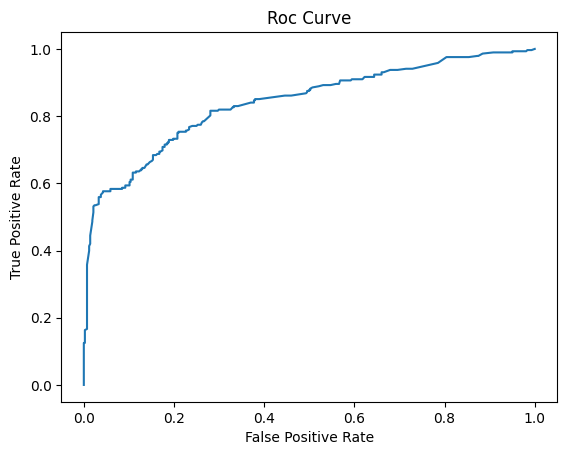

In [349]:
# Dibuixem la ROC Curve
fPositive, tPositive, thresholds = roc_curve(y, prob)
ROC_AUC = roc_auc_score(y, prob)
print("ROC AUC:", ROC_AUC)
plt.title("Roc Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(fPositive, tPositive)

AUPRC: 0.8267968860865721


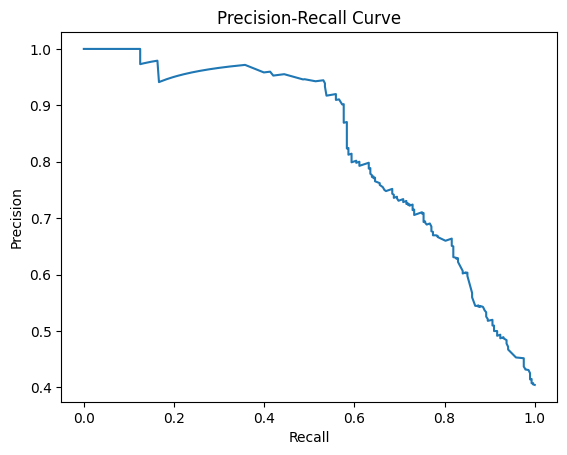

In [350]:
# Dibuixem la Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y, prob)
AUPRC = average_precision_score(y, prob)
print("AUPRC:", AUPRC)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot(recall, precision)

Classification_report ens mostra les mètriques de precision, recall, f1-score i suport. Precision mesura el percentatge d'elements d'una clase es troben en el nombre total d'elements d'aquesta classe. Recall indica el percentatge dels que han estat classificats correctament en aquesta classe. F1-score és la mitjana armònica entre precision i recall. Suport és el nombre d'elements de cada classe. Podem veure que tant precision com recall presenten un major percentatge, +10% i 7%, respectivament, en la classe 0. Això podria deure's a que les dades no estan balancejades.

In [351]:
y_pred = logReg.predict(X)

metriques = classification_report(y, y_pred)
print('Mètriques:\n', metriques)

Mètriques:
               precision    recall  f1-score   support

         0.0       0.82      0.80      0.81       424
         1.0       0.72      0.73      0.72       288

    accuracy                           0.77       712
   macro avg       0.77      0.77      0.77       712
weighted avg       0.77      0.77      0.77       712



### 4. Model Selection amb validacio creuada (4 punts)

Fent servir la metrica trobada en l'apartat anterior, en aquest apartat caldra seleccionar una serie de models i, fent us de la validacio creuada, seleccionar el millor model amb els seus respectius millors hyperparametres que haurem buscat fent hyperparameter search.

La tasca d'aquesta pràctica s'enmarca dins l'aprenentatge computacional **supervisat**. A sklearn, disposem de varies tècniques [(veure documentació)](https://scikit-learn.org/stable/supervised_learning.html). A les classes de teoria, hem vist varies tècniques, com ara logistic regression, SVM amb diferents kernels, Nearest Neighbour... i tambe coneixeu altres tecniques d'altres cursos, com els arbres de decisio. Ademes, en la classe de problemes hem donat tambe els random forest i els gradient boosting. Per aquest apartat es demana seleccionar **un minim de 4 models** (per exemple, regressio logistica, random forest, KNN, SVM).

**Preguntes:**
* Quins models heu considerat? Perque els heu seleccionat?
* Fent servir validacio creuada, escolliu el millor model (agafant els hiperparamtres per defecte). Recordeu fer servir la metrica utilitzada en l'apartat anterior. Perque es important fer servir validacio creuada? Heu de fer servir algun [tipus de validacio creuada](https://scikit-learn.org/stable/modules/cross_validation.html) en especial?

* Seleccioneu una serie d'hyperparametres a provar per cadascun dels models i realitzeu una cerca d'hyperparametres. Hi ha algun model que creieu que podeu descartar de primeres? Perque?

* Mostreu els resultats en una taula on es mostri el model, els experiments realitzats i els resultats obtinguts (tant en train com en test). Podeu mostrar tambe el temps d'entrenament de cada model.

* Quin tipus de K-fold heu escollit en la seleccio de models? I en la seleccio de models amb hyperparametres? Com afecta al resultat modificar el numero de k (numero de folds) al resultat?

* Quines formes de buscar el millor parametre heu trobat? Són costoses computacionalment parlant? [documentació](https://scikit-learn.org/stable/modules/grid_search.html) Quina heu seleccionat?

* Si disposem de recursos limitats (per exemple, un PC durant 1 hora) quin dels métodes creieu que obtindrà millor resultat final?

* Existeixen altres mètodes de búsqueda més eficients ([scikit-optimize](https://scikit-optimize.github.io/stable/))?

* Opcional : Feu la prova, i amb el model i el metode de crossvalidació escollit, configureu els diferents metodes de búsqueda per a que s'executin durant el mateix temps (i.e. depenent del problema, 0,5h-1 hora). Analitzeu quin ha arribat a una millor solució. (Ajuda: estimeu el temps que trigarà a fer 1 training el vostre model, i aixi trobeu el número de intents que podeu fer en cada cas.)


Hem escollit Grid Search per trobar els millors paràmetres, encara que és computacionalment costosa, perquè entrena i avalua múltiples models.

In [352]:
# Fem la divisió en train i test, establint un 70% pel train i un 30% pel test

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

Hem triat els models de Regressio Logística, Random Forest, KNN i SVM. Considerem que aquests models són adequats per problemes de classificació, també per quan són de classificació binària com és el nostre cas.

Per escollir el millor model emprem K-fold cross validation. Consisteix en dividir les dades en K parts, de manera que s'entrena el model en K-1 parts i es testeja amb la part restant, repetint el procés K vegades. Després es fa un promig de les mètriques de rendiment per obtenir una estimació més fiable de quin ha sigut el rendiment del model.
Pels 4 models, ja sigui amb els hyperparametres per defecte com cercant els millors, emprem K-fold cross validation i busquem quina és la k que ens dona un millor f1-score.


# **Hyperparametres per defecte**

**Regressió Logística**

k = 2, 0.71 f1_score amb una desviació estandard de 0.01
k = 3, 0.72 f1_score amb una desviació estandard de 0.04
k = 4, 0.73 f1_score amb una desviació estandard de 0.04
k = 5, 0.73 f1_score amb una desviació estandard de 0.04
k = 6, 0.73 f1_score amb una desviació estandard de 0.07
k = 7, 0.72 f1_score amb una desviació estandard de 0.06
k = 8, 0.73 f1_score amb una desviació estandard de 0.08
k = 9, 0.72 f1_score amb una desviació estandard de 0.09
k = 10, 0.73 f1_score amb una desviació estandard de 0.09
k = 11, 0.72 f1_score amb una desviació estandard de 0.10
k = 12, 0.72 f1_score amb una desviació estandard de 0.09
k = 13, 0.72 f1_score amb una desviació estandard de 0.11
k = 14, 0.72 f1_score amb una desviació estandard de 0.08
k = 15, 0.71 f1_score amb una desviació estandard de 0.10
k = 16, 0.72 f1_score amb una desviació estandard de 0.12
k = 17, 0.71 f1_score amb una desviació estandard de 0.12
k = 18, 0.71 f1_score amb una desviació estandard de 0.12
k = 19, 0.72 f1_score 

([<matplotlib.axis.XTick at 0x7b85c21bf5b0>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20')])

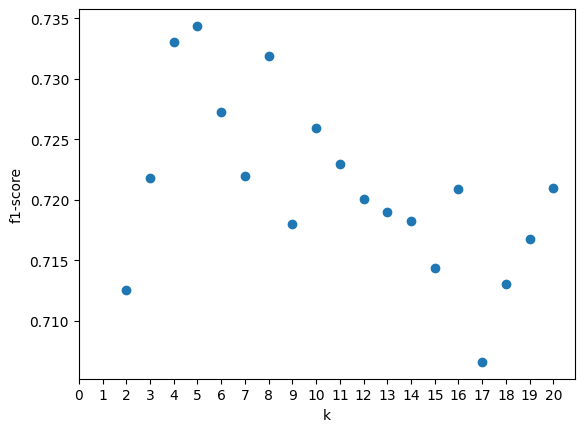

In [353]:
logReg = LogisticRegression()

# Busquem la millor k per al cross validation
k_range = range(2,21)
scores = []
for k in k_range:
    score = cross_val_score(logReg, X_train, y_train, cv=k, scoring='f1')
    print("k = %d, %0.2f f1_score amb una desviació estandard de %0.2f" % (k, score.mean(), score.std()))
    scores.append(score.mean())

plt.figure()
plt.xlabel('k')
plt.ylabel('f1-score')
plt.scatter(k_range, scores)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

In [354]:
# La millor k és 5 perquè té un f1-score de 0.73 i una desviació estandard de 0.04

cross_val_score(logReg, X_train, y_train, cv=5, scoring='f1')

array([0.68235294, 0.7654321 , 0.79518072, 0.70886076, 0.72      ])

In [355]:
inicio = time.time()

logReg.fit(X_train, y_train)

y_pred = logReg.predict(X_test)
metriques = classification_report(y_test, y_pred)
print('Mètriques:\n', metriques)

final = time.time()
tiempo=final-inicio
print("Temps d'entrenament", tiempo)

Mètriques:
               precision    recall  f1-score   support

         0.0       0.76      0.81      0.79       122
         1.0       0.73      0.66      0.69        92

    accuracy                           0.75       214
   macro avg       0.74      0.74      0.74       214
weighted avg       0.75      0.75      0.75       214

Temps d'entrenament 0.02660536766052246


AUPRC: 0.7927866987451271


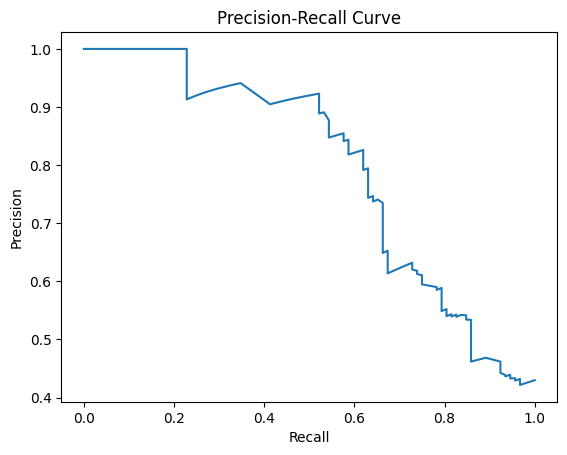

In [356]:
# Mostrem la Precision-Recall Curve

prob = logReg.predict_proba(X_test)
prob = prob[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, prob)
AUPRC = average_precision_score(y_test, prob)
print("AUPRC:", AUPRC)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot(recall, precision)

**Random Forest**

k = 2, 0.70 f1_score amb una desviació estandard de 0.02
k = 3, 0.70 f1_score amb una desviació estandard de 0.04
k = 4, 0.73 f1_score amb una desviació estandard de 0.04
k = 5, 0.71 f1_score amb una desviació estandard de 0.02
k = 6, 0.73 f1_score amb una desviació estandard de 0.03
k = 7, 0.72 f1_score amb una desviació estandard de 0.04
k = 8, 0.72 f1_score amb una desviació estandard de 0.08
k = 9, 0.72 f1_score amb una desviació estandard de 0.09
k = 10, 0.73 f1_score amb una desviació estandard de 0.07
k = 11, 0.71 f1_score amb una desviació estandard de 0.10
k = 12, 0.72 f1_score amb una desviació estandard de 0.10
k = 13, 0.72 f1_score amb una desviació estandard de 0.08
k = 14, 0.71 f1_score amb una desviació estandard de 0.06
k = 15, 0.71 f1_score amb una desviació estandard de 0.10
k = 16, 0.72 f1_score amb una desviació estandard de 0.12
k = 17, 0.72 f1_score amb una desviació estandard de 0.10
k = 18, 0.72 f1_score amb una desviació estandard de 0.10
k = 19, 0.72 f1_score 

([<matplotlib.axis.XTick at 0x7b85c963cb80>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20')])

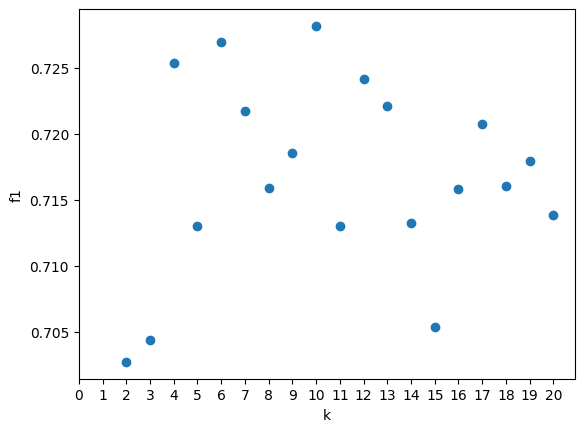

In [357]:
randomForest = RandomForestClassifier()

# Busquem la millor k per al cross validation
k_range = range(2,21)
scores = []
for k in k_range:
    score = cross_val_score(randomForest, X_train, y_train, cv=k, scoring='f1')
    print("k = %d, %0.2f f1_score amb una desviació estandard de %0.2f" % (k, score.mean(), score.std()))
    scores.append(score.mean())

plt.figure()
plt.xlabel('k')
plt.ylabel('f1')
plt.scatter(k_range, scores)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

In [358]:
# La millor k és 10 perquè té un f1-score de 0.73 i una desviació estandard de 0.07

cross_val_score(randomForest, X_train, y_train, cv=10, scoring='f1')

array([0.75555556, 0.61111111, 0.74285714, 0.74285714, 0.75675676,
       0.75      , 0.76470588, 0.75675676, 0.8       , 0.6       ])

In [359]:
inicio = time.time()

randomForest.fit(X_train, y_train)

y_pred = randomForest.predict(X_test)
metriques = classification_report(y_test, y_pred)
print('Mètriques:\n', metriques)

final = time.time()
tiempo=final-inicio
print("Temps d'entrenament", tiempo)

Mètriques:
               precision    recall  f1-score   support

         0.0       0.76      0.85      0.80       122
         1.0       0.77      0.64      0.70        92

    accuracy                           0.76       214
   macro avg       0.76      0.75      0.75       214
weighted avg       0.76      0.76      0.76       214

Temps d'entrenament 0.33262133598327637


AUPRC: 0.7502875421799577


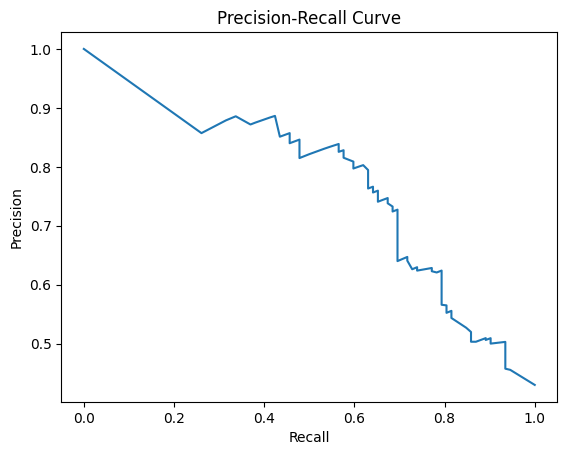

In [360]:
# Mostrem la Precision-Recall Curve

prob = randomForest.predict_proba(X_test)
prob = prob[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, prob)
AUPRC = average_precision_score(y_test, prob)
print("AUPRC:", AUPRC)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot(recall, precision)

**KNN**

k = 2, 0.70 f1_score amb una desviació estandard de 0.02
k = 3, 0.72 f1_score amb una desviació estandard de 0.02
k = 4, 0.70 f1_score amb una desviació estandard de 0.03
k = 5, 0.69 f1_score amb una desviació estandard de 0.03
k = 6, 0.69 f1_score amb una desviació estandard de 0.07
k = 7, 0.70 f1_score amb una desviació estandard de 0.05
k = 8, 0.69 f1_score amb una desviació estandard de 0.06
k = 9, 0.69 f1_score amb una desviació estandard de 0.08
k = 10, 0.69 f1_score amb una desviació estandard de 0.08
k = 11, 0.68 f1_score amb una desviació estandard de 0.10
k = 12, 0.68 f1_score amb una desviació estandard de 0.10
k = 13, 0.68 f1_score amb una desviació estandard de 0.09
k = 14, 0.69 f1_score amb una desviació estandard de 0.08
k = 15, 0.68 f1_score amb una desviació estandard de 0.10
k = 16, 0.68 f1_score amb una desviació estandard de 0.07
k = 17, 0.67 f1_score amb una desviació estandard de 0.11
k = 18, 0.68 f1_score amb una desviació estandard de 0.12
k = 19, 0.68 f1_score 

([<matplotlib.axis.XTick at 0x7b85c1fe6f80>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20')])

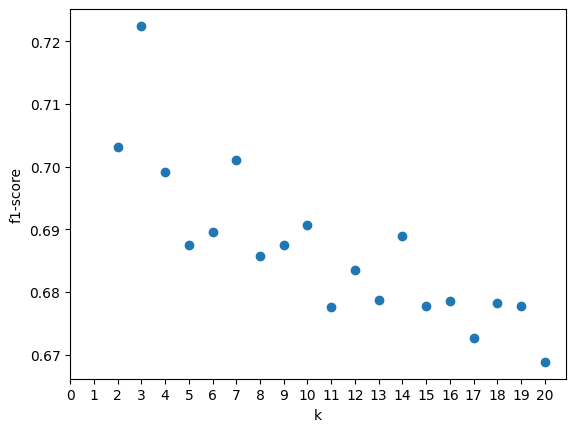

In [361]:
KNN = KNeighborsClassifier()

# Mirem quina és la millor k per al cross_validation
k_range = range(2,21)
scores = []
for k in k_range:
    score = cross_val_score(KNN, X_train, y_train, cv=k, scoring='f1')
    print("k = %d, %0.2f f1_score amb una desviació estandard de %0.2f" % (k, score.mean(), score.std()))
    scores.append(score.mean())

plt.figure()
plt.xlabel('k')
plt.ylabel('f1-score')
plt.scatter(k_range, scores)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

In [362]:
# La millor k és 3 perquè té un f1-score de 0.72 i una desviació estandard de 0.02

cross_val_score(KNN, X_train, y_train, cv=3, scoring='f1')

array([0.71317829, 0.75409836, 0.7       ])

In [363]:
inicio = time.time()

KNN.fit(X_train, y_train)

y_pred = KNN.predict(X_test)
metriques = classification_report(y_test, y_pred)
print('Mètriques:\n', metriques)

final = time.time()
tiempo=final-inicio
print("Temps d'entrenament", tiempo)

Mètriques:
               precision    recall  f1-score   support

         0.0       0.72      0.76      0.74       122
         1.0       0.65      0.60      0.62        92

    accuracy                           0.69       214
   macro avg       0.69      0.68      0.68       214
weighted avg       0.69      0.69      0.69       214

Temps d'entrenament 0.062387704849243164


AUPRC: 0.7065400019249777


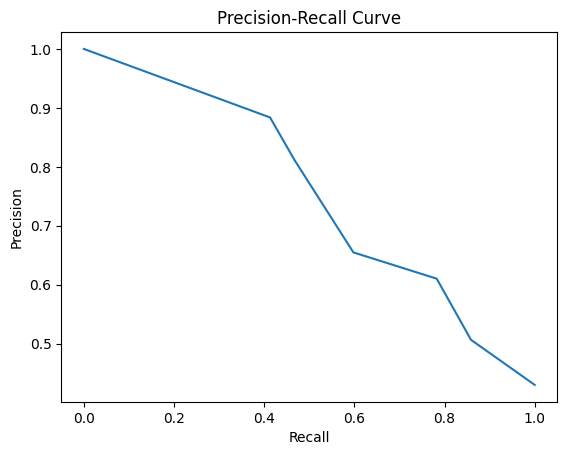

In [364]:
# Mostrem la Precision-Recall Curve

prob = KNN.predict_proba(X_test)
prob = prob[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, prob)
AUPRC = average_precision_score(y_test, prob)
print("AUPRC:", AUPRC)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot(recall, precision)

**SVM**

k = 2, 0.70 f1_score amb una desviació estandard de 0.02
k = 3, 0.69 f1_score amb una desviació estandard de 0.03
k = 4, 0.70 f1_score amb una desviació estandard de 0.02
k = 5, 0.70 f1_score amb una desviació estandard de 0.04
k = 6, 0.70 f1_score amb una desviació estandard de 0.08
k = 7, 0.70 f1_score amb una desviació estandard de 0.05
k = 8, 0.70 f1_score amb una desviació estandard de 0.06
k = 9, 0.70 f1_score amb una desviació estandard de 0.07
k = 10, 0.71 f1_score amb una desviació estandard de 0.09
k = 11, 0.70 f1_score amb una desviació estandard de 0.10
k = 12, 0.70 f1_score amb una desviació estandard de 0.10
k = 13, 0.70 f1_score amb una desviació estandard de 0.09
k = 14, 0.70 f1_score amb una desviació estandard de 0.10
k = 15, 0.70 f1_score amb una desviació estandard de 0.12
k = 16, 0.70 f1_score amb una desviació estandard de 0.10
k = 17, 0.70 f1_score amb una desviació estandard de 0.10
k = 18, 0.69 f1_score amb una desviació estandard de 0.14
k = 19, 0.70 f1_score 

([<matplotlib.axis.XTick at 0x7b85c1d020b0>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20')])

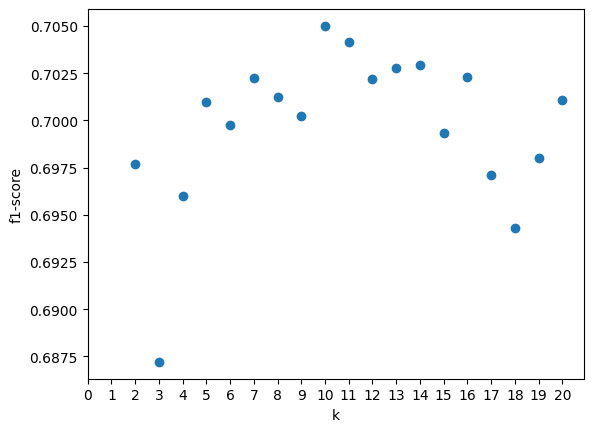

In [365]:
svmRadial = svm.SVC(probability=True)

# Mirem quina és la millor k per al cross_validation
k_range = range(2,21)
scores = []
for k in k_range:
    score = cross_val_score(svmRadial, X_train, y_train, cv=k, scoring='f1')
    print("k = %d, %0.2f f1_score amb una desviació estandard de %0.2f" % (k, score.mean(), score.std()))
    scores.append(score.mean())

plt.figure()
plt.xlabel('k')
plt.ylabel('f1-score')
plt.scatter(k_range, scores)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

In [366]:
# La millor k és 10 perquè té un f1-score de 0.71 i una desviació estandard de 0.09

cross_val_score(svmRadial, X_train, y_train, cv=10, scoring='f1')

array([0.77777778, 0.6875    , 0.76470588, 0.72727273, 0.625     ,
       0.78787879, 0.73333333, 0.48275862, 0.77419355, 0.68965517])

In [367]:
inicio = time.time()

svmRadial.fit(X_train, y_train)

y_pred = svmRadial.predict(X_test)
metriques = classification_report(y_test, y_pred)
print('Mètriques:\n', metriques)

final = time.time()
tiempo=final-inicio
print("Temps d'entrenament", tiempo)

Mètriques:
               precision    recall  f1-score   support

         0.0       0.74      0.93      0.82       122
         1.0       0.85      0.57      0.68        92

    accuracy                           0.77       214
   macro avg       0.80      0.75      0.75       214
weighted avg       0.79      0.77      0.76       214

Temps d'entrenament 0.09564876556396484


AUPRC: 0.8098752149944235


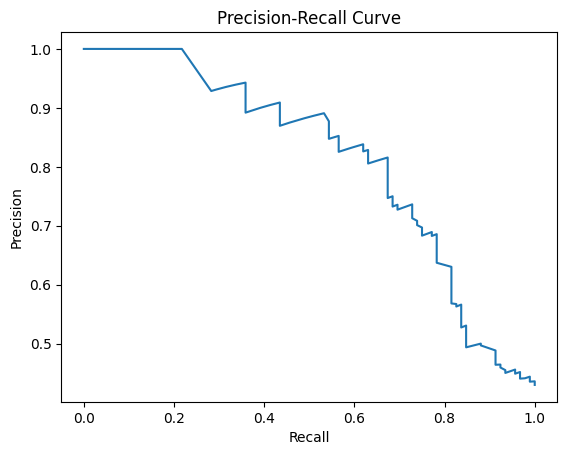

In [368]:
# Mostrem la Precision-Recall Curve

prob = svmRadial.predict_proba(X_test)
prob = prob[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, prob)
AUPRC = average_precision_score(y_test, prob)
print("AUPRC:", AUPRC)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot(recall, precision)

# **Cerca d'hyperparametres**

La cerca del millor hyperparametre la fem amb GridSearchCV. Es basa en una quadricula que representa totes les combinacions possibles dels valors dels hyperparametres que volem avaluar. Llavors per cadascuna d'aquesta combinacions s'estrena un model i s'evalua el seu rendiment amb una mètrica. Després es selecciona el model que té un millor rendiment en funció de la mètrica escollida. És una forma clarament costosa a nivell computacional perquè cal valorar totes les combinacions dels valors dels hyperparametres.

**Regressió Logística**

In [369]:
# Establim els valors de C (regularització) que volem avaluar
hyperparametres = {'C': [0.01, 0.1, 0.5, 1, 2, 3, 4, 5, 7, 10]}

gridSearch = GridSearchCV(estimator=LogisticRegression(),param_grid=hyperparametres,
                          cv=3, scoring='f1', refit='f1', n_jobs=-1)

gridSearch.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 0.5, 1, 2, 3, 4, 5, 7, 10]},
             refit='f1', scoring='f1')

Regressió Logística: LogisticRegression(C=5, random_state=0)
k = 2, 0.71 f1_score amb una desviació estandard de 0.00
k = 3, 0.73 f1_score amb una desviació estandard de 0.05
k = 4, 0.73 f1_score amb una desviació estandard de 0.04
k = 5, 0.73 f1_score amb una desviació estandard de 0.04
k = 6, 0.73 f1_score amb una desviació estandard de 0.07
k = 7, 0.72 f1_score amb una desviació estandard de 0.06
k = 8, 0.73 f1_score amb una desviació estandard de 0.08
k = 9, 0.72 f1_score amb una desviació estandard de 0.09
k = 10, 0.73 f1_score amb una desviació estandard de 0.10
k = 11, 0.72 f1_score amb una desviació estandard de 0.10
k = 12, 0.72 f1_score amb una desviació estandard de 0.09
k = 13, 0.72 f1_score amb una desviació estandard de 0.11
k = 14, 0.72 f1_score amb una desviació estandard de 0.08
k = 15, 0.72 f1_score amb una desviació estandard de 0.10
k = 16, 0.73 f1_score amb una desviació estandard de 0.12
k = 17, 0.71 f1_score amb una desviació estandard de 0.12
k = 18, 0.72 f1_sco

([<matplotlib.axis.XTick at 0x7b85c1c33580>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20')])

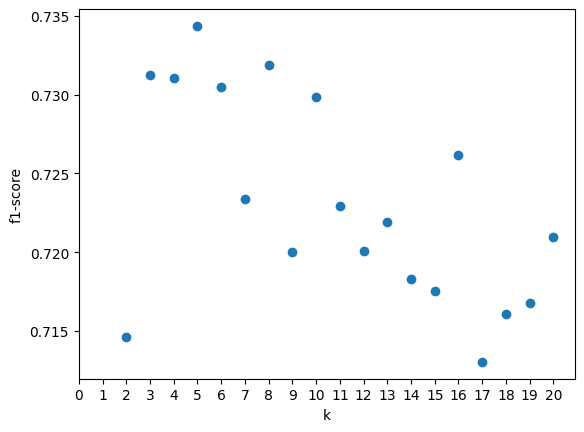

In [370]:
logReg = LogisticRegression(C=gridSearch.best_params_.get('C'), random_state=0)
print("Regressió Logística:", logReg)
# Busquem la millor k per al cross validation
k_range = range(2,21)
scores = []
for k in k_range:
    score = cross_val_score(logReg, X_train, y_train, cv=k, scoring='f1')
    print("k = %d, %0.2f f1_score amb una desviació estandard de %0.2f" % (k, score.mean(), score.std()))
    scores.append(score.mean())

plt.figure()
plt.xlabel('k')
plt.ylabel('f1-score')
plt.scatter(k_range, scores)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

In [371]:
# Que la regularització (C) sigui 5 vol dir que el model no és estricte, pel que s'adapta a les dades d'entrenament, i no penalitza tant els errors
# La millor k és 5 perquè té un f1-score de 0.73 i una desviació estandard de 0.04

cross_val_score(logReg, X_train, y_train, cv=5, scoring='f1')

array([0.68235294, 0.7654321 , 0.79518072, 0.70886076, 0.72      ])

In [372]:
inicio = time.time()

logReg.fit(X_train, y_train)

y_pred = logReg.predict(X_test)
metriques = classification_report(y_test, y_pred)
print('Mètriques:\n', metriques)

final = time.time()
tiempo=final-inicio
print("Temps d'entrenament", tiempo)

Mètriques:
               precision    recall  f1-score   support

         0.0       0.76      0.81      0.79       122
         1.0       0.73      0.66      0.69        92

    accuracy                           0.75       214
   macro avg       0.74      0.74      0.74       214
weighted avg       0.75      0.75      0.75       214

Temps d'entrenament 0.015758514404296875


AUPRC: 0.7927866987451271


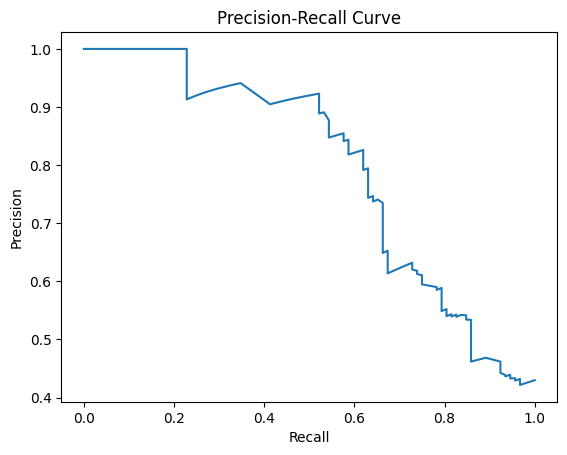

In [373]:
# Mostrem la Precision-Recall Curve

prob = logReg.predict_proba(X_test)
prob = prob[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, prob)
AUPRC = average_precision_score(y_test, prob)
print("AUPRC:", AUPRC)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot(recall, precision)

**Random Forest**

In [374]:
# Establim els valors de n_estimators o arbres que volem avaluar
hyperparametres = {'n_estimators': [10, 25, 50, 75, 100]}

gridSearch = GridSearchCV(estimator=RandomForestClassifier(), param_grid=hyperparametres,
                          cv=3, scoring='f1', refit='f1', n_jobs=-1)

gridSearch.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'n_estimators': [10, 25, 50, 75, 100]}, refit='f1',
             scoring='f1')

Random Forest: RandomForestClassifier(random_state=0)
k = 2, 0.69 f1_score amb una desviació estandard de 0.01
k = 3, 0.73 f1_score amb una desviació estandard de 0.03
k = 4, 0.72 f1_score amb una desviació estandard de 0.03
k = 5, 0.73 f1_score amb una desviació estandard de 0.03
k = 6, 0.73 f1_score amb una desviació estandard de 0.03
k = 7, 0.73 f1_score amb una desviació estandard de 0.04
k = 8, 0.72 f1_score amb una desviació estandard de 0.07
k = 9, 0.72 f1_score amb una desviació estandard de 0.07
k = 10, 0.73 f1_score amb una desviació estandard de 0.06
k = 11, 0.71 f1_score amb una desviació estandard de 0.09
k = 12, 0.71 f1_score amb una desviació estandard de 0.10
k = 13, 0.72 f1_score amb una desviació estandard de 0.08
k = 14, 0.72 f1_score amb una desviació estandard de 0.06
k = 15, 0.72 f1_score amb una desviació estandard de 0.09
k = 16, 0.71 f1_score amb una desviació estandard de 0.10
k = 17, 0.71 f1_score amb una desviació estandard de 0.10
k = 18, 0.72 f1_score amb 

([<matplotlib.axis.XTick at 0x7b85c1b46620>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20')])

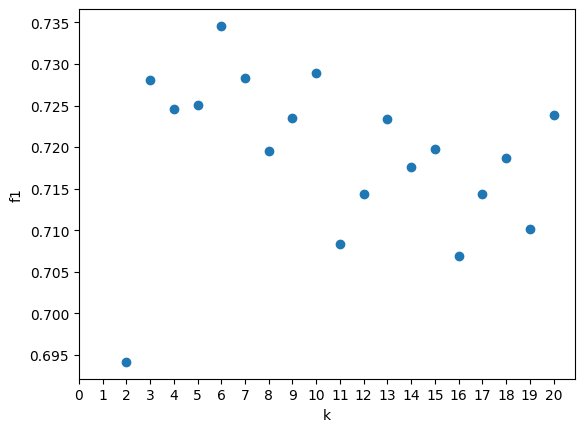

In [375]:
randomForest = RandomForestClassifier(n_estimators=gridSearch.best_params_.get('n_estimators'), random_state=0)
print("Random Forest:", randomForest)
# Busquem la millor k per al cross validation
k_range = range(2,21)
scores = []
for k in k_range:
    score = cross_val_score(randomForest, X_train, y_train, cv=k, scoring='f1')
    print("k = %d, %0.2f f1_score amb una desviació estandard de %0.2f" % (k, score.mean(), score.std()))
    scores.append(score.mean())

plt.figure()
plt.xlabel('k')
plt.ylabel('f1')
plt.scatter(k_range, scores)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

In [322]:
# El valor òptim trobat de n_estimators es 100, igual que per defecte
# La millor k és 6 perquè té un f1-score de 0.73 i una desviació estandard de 0.03

cross_val_score(randomForest, X_train, y_train, cv=6, scoring='f1')

array([0.73846154, 0.68085106, 0.71698113, 0.71698113, 0.76923077,
       0.8       , 0.68085106])

In [376]:
inicio = time.time()

randomForest.fit(X_train, y_train)

y_pred = randomForest.predict(X_test)
metriques = classification_report(y_test, y_pred)
print('Mètriques:\n', metriques)

final = time.time()
tiempo=final-inicio
print("Temps d'entrenament", tiempo)

Mètriques:
               precision    recall  f1-score   support

         0.0       0.76      0.86      0.81       122
         1.0       0.78      0.64      0.70        92

    accuracy                           0.77       214
   macro avg       0.77      0.75      0.76       214
weighted avg       0.77      0.77      0.76       214

Temps d'entrenament 0.22678613662719727


AUPRC: 0.7487634659445209


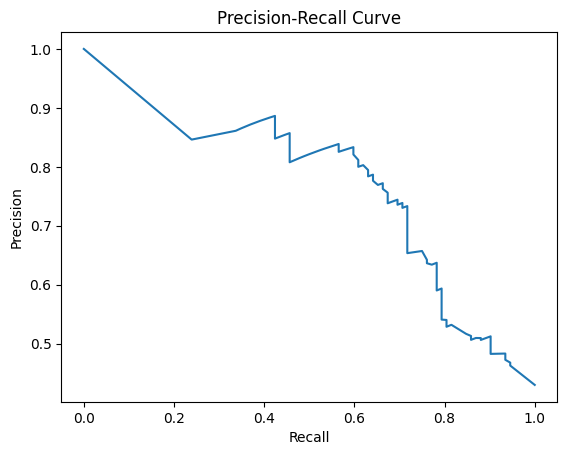

In [377]:
# Mostrem la Precision-Recall Curve

prob = randomForest.predict_proba(X_test)
prob = prob[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, prob)
AUPRC = average_precision_score(y_test, prob)
print("AUPRC:", AUPRC)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot(recall, precision)

**KNN**

In [378]:
hyperparametres = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]}

gridSearch = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=hyperparametres,
                          cv=3, scoring='f1', refit='f1', n_jobs=-1)

gridSearch.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19]},
             refit='f1', scoring='f1')

In [379]:
# Ajustem el model amb la millor k, que es aquest cas és 8
KNN = KNeighborsClassifier(n_neighbors=gridSearch.best_params_.get('n_neighbors'))
print("KNN:", KNN)

KNN: KNeighborsClassifier(n_neighbors=8)


k = 2, 0.71 f1_score amb una desviació estandard de 0.02
k = 3, 0.72 f1_score amb una desviació estandard de 0.01
k = 4, 0.70 f1_score amb una desviació estandard de 0.02
k = 5, 0.72 f1_score amb una desviació estandard de 0.02
k = 6, 0.71 f1_score amb una desviació estandard de 0.06
k = 7, 0.69 f1_score amb una desviació estandard de 0.05
k = 8, 0.69 f1_score amb una desviació estandard de 0.07
k = 9, 0.70 f1_score amb una desviació estandard de 0.07
k = 10, 0.70 f1_score amb una desviació estandard de 0.06
k = 11, 0.69 f1_score amb una desviació estandard de 0.09
k = 12, 0.69 f1_score amb una desviació estandard de 0.09
k = 13, 0.68 f1_score amb una desviació estandard de 0.09
k = 14, 0.70 f1_score amb una desviació estandard de 0.07
k = 15, 0.69 f1_score amb una desviació estandard de 0.08
k = 16, 0.68 f1_score amb una desviació estandard de 0.09
k = 17, 0.69 f1_score amb una desviació estandard de 0.09
k = 18, 0.69 f1_score amb una desviació estandard de 0.10
k = 19, 0.69 f1_score 

([<matplotlib.axis.XTick at 0x7b85c1a71b10>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20')])

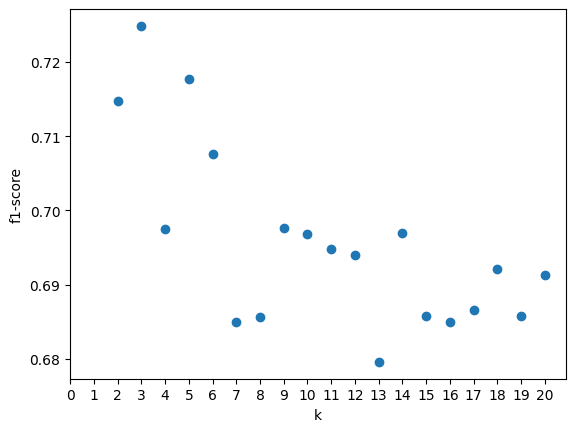

In [380]:
# Mirem quina és la millor k per al cross_validation
k_range = range(2,21)
scores = []
for k in k_range:
    score = cross_val_score(KNN, X_train, y_train, cv=k, scoring='f1')
    print("k = %d, %0.2f f1_score amb una desviació estandard de %0.2f" % (k, score.mean(), score.std()))
    scores.append(score.mean())

plt.figure()
plt.xlabel('k')
plt.ylabel('f1-score')
plt.scatter(k_range, scores)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

In [381]:
# La millor k és 3 perquè té un f1-score de 0.72 i una desviació estandard de 0.01

cross_val_score(KNN, X_train, y_train, cv=3, scoring='f1')

array([0.73333333, 0.73214286, 0.70909091])

In [382]:
inicio = time.time()

KNN.fit(X_train, y_train)

y_pred = KNN.predict(X_test)
metriques = classification_report(y_test, y_pred)
print('Mètriques:\n', metriques)

final = time.time()
tiempo=final-inicio
print("Temps d'entrenament", tiempo)

Mètriques:
               precision    recall  f1-score   support

         0.0       0.73      0.89      0.80       122
         1.0       0.79      0.57      0.66        92

    accuracy                           0.75       214
   macro avg       0.76      0.73      0.73       214
weighted avg       0.75      0.75      0.74       214

Temps d'entrenament 0.053458213806152344


AUPRC: 0.7321851170792867


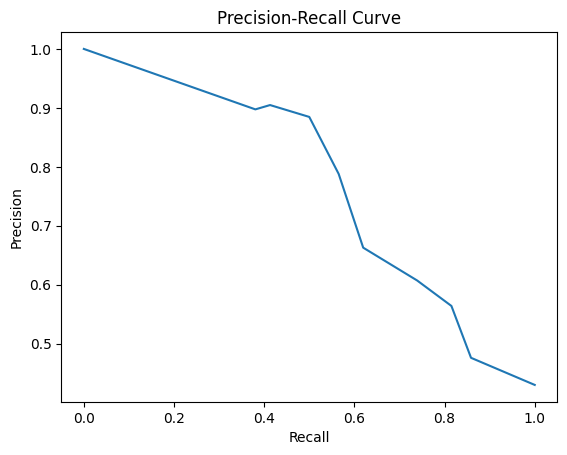

In [383]:
# Mostrem la Precision-Recall Curve

prob = KNN.predict_proba(X_test)
prob = prob[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, prob)
AUPRC = average_precision_score(y_test, prob)
print("AUPRC:", AUPRC)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot(recall, precision)

**SVM**

In [384]:
# Establim els valors de C (cost) que volem avaluar
hyperparametres = {'C': [0.01, 0.1, 0.5, 1, 2, 3, 4, 5, 7, 10]}

gridSearch = GridSearchCV(estimator = svm.SVC(random_state=0),
                          param_grid=hyperparametres, cv=3, scoring='f1', refit='f1', n_jobs=-1)

gridSearch.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=SVC(random_state=0), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 0.5, 1, 2, 3, 4, 5, 7, 10]},
             refit='f1', scoring='f1')

SVM amb kernel Radial: SVC(C=3, probability=True)
k = 2, 0.69 f1_score amb una desviació estandard de 0.02
k = 3, 0.70 f1_score amb una desviació estandard de 0.03
k = 4, 0.70 f1_score amb una desviació estandard de 0.02
k = 5, 0.70 f1_score amb una desviació estandard de 0.04
k = 6, 0.70 f1_score amb una desviació estandard de 0.08
k = 7, 0.70 f1_score amb una desviació estandard de 0.05
k = 8, 0.69 f1_score amb una desviació estandard de 0.06
k = 9, 0.69 f1_score amb una desviació estandard de 0.07
k = 10, 0.70 f1_score amb una desviació estandard de 0.09
k = 11, 0.70 f1_score amb una desviació estandard de 0.10
k = 12, 0.70 f1_score amb una desviació estandard de 0.10
k = 13, 0.70 f1_score amb una desviació estandard de 0.09
k = 14, 0.70 f1_score amb una desviació estandard de 0.09
k = 15, 0.69 f1_score amb una desviació estandard de 0.11
k = 16, 0.70 f1_score amb una desviació estandard de 0.09
k = 17, 0.69 f1_score amb una desviació estandard de 0.09
k = 18, 0.69 f1_score amb una 

([<matplotlib.axis.XTick at 0x7b85c196e1a0>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20')])

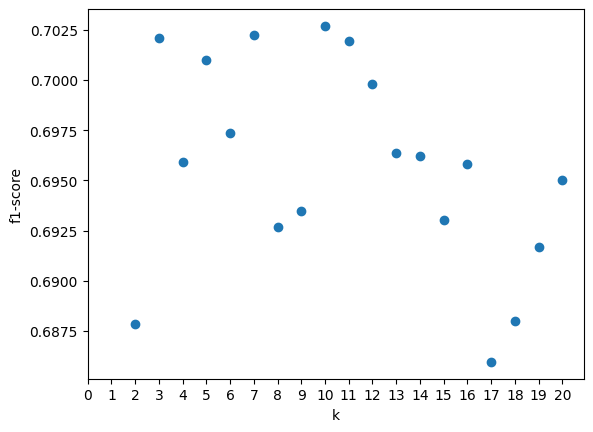

In [385]:
svmRadial = svm.SVC(kernel='rbf', C=gridSearch.best_params_.get('C'), probability=True)
print("SVM amb kernel Radial:", svmRadial)
# Mirem quina és la millor k per al cross_validation
k_range = range(2,21)
scores = []
for k in k_range:
    score = cross_val_score(svmRadial, X_train, y_train, cv=k, scoring='f1')
    print("k = %d, %0.2f f1_score amb una desviació estandard de %0.2f" % (k, score.mean(), score.std()))
    scores.append(score.mean())

plt.figure()
plt.xlabel('k')
plt.ylabel('f1-score')
plt.scatter(k_range, scores)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

In [386]:
# Que el valor de C sigui 3 implica que no ha sigut ni molt flexible ni molt estricte a l'hora de buscar
# el pla de separació, llavors ni el marge de separació és molt ampli ni molt estret
# La millor k és 10 perquè té un f1-score de 0.70 i una desviació estandard de 0.09

cross_val_score(svmRadial, X_train, y_train, cv=10, scoring='f1')

array([0.77777778, 0.6875    , 0.76470588, 0.72727273, 0.625     ,
       0.76470588, 0.73333333, 0.48275862, 0.77419355, 0.68965517])

In [387]:
inicio = time.time()

svmRadial.fit(X_train, y_train)

y_pred = svmRadial.predict(X_test)
metriques = classification_report(y_test, y_pred)
print('Mètriques:\n', metriques)

final = time.time()
tiempo=final-inicio
print("Temps d'entrenament", tiempo)

Mètriques:
               precision    recall  f1-score   support

         0.0       0.74      0.93      0.82       122
         1.0       0.85      0.57      0.68        92

    accuracy                           0.77       214
   macro avg       0.80      0.75      0.75       214
weighted avg       0.79      0.77      0.76       214

Temps d'entrenament 0.05171513557434082


AUPRC: 0.7923832900655055


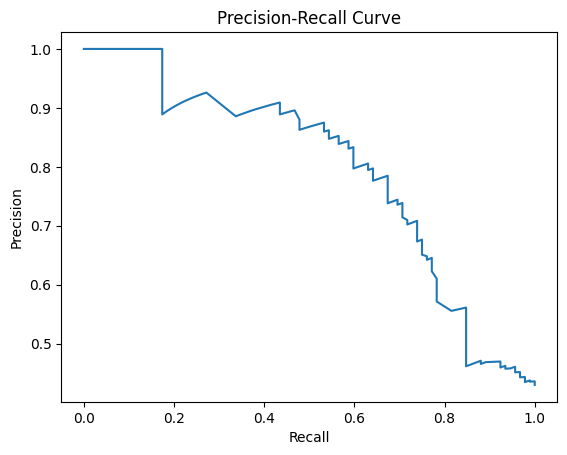

In [388]:
# Mostrem la Precision-Recall Curve

prob = svmRadial.predict_proba(X_test)
prob = prob[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, prob)
AUPRC = average_precision_score(y_test, prob)
print("AUPRC:", AUPRC)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot(recall, precision)

# **Conclusions**

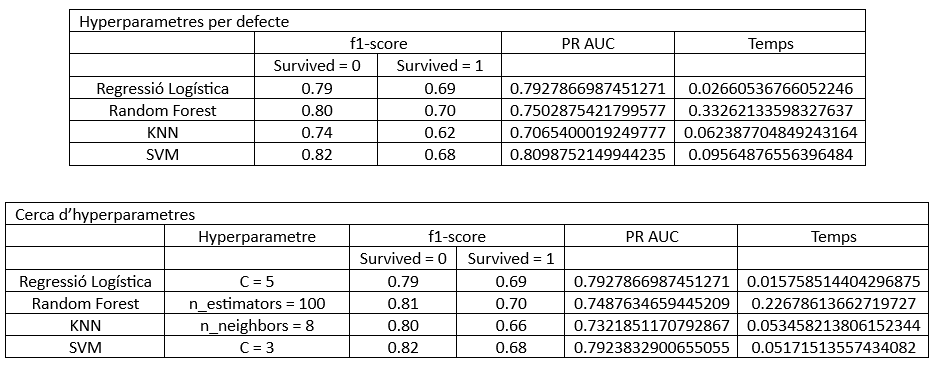

Pel que fa al cas del hyperparametres per defecte, si ens fixem en la nostra mètrica als classification_report dels models veiem que els millors són Regressió Logística i SVM perquè el seu f1-score a la classe 1 es gaire similar, tot i que SVM triga una mica més, però és despreciable. Sobre l'AUC de la Precision-Recall Curve, podem dir que novament ens permet dir que els millors models són Regressió Logística i SVM perquè el seu valor és bastant similar, presenten un bon rendiment.

En el cas de la cerca d'hyperparametres, a partir de l'f1-score a la classe 1, que és la que ens interessa realment, veiem que tant Regressió Logística com SVM classifiquen de forma similar i són els millors models, tot i que la Regressió Logística implica un temps d'entrenament menor. A partir de l'AUC de la PR Curve també constatem que aquests models són els més eficients.

### 5.Analisi Final (1.5 punt)

Un cop seleccionat el millor model amb els millors hiperparamtres, caldra fer un report final amb els resultats obtinguts.

Preguntes:
* Mostreu les curves ROC/PR (la que hageu escollit en l'apartat 2) i interpreteu els resultats.

* Analitzeu en detall les diferents metriques que trobeu adients i comenteu per sobre com podrieu fer servir aquest model en un futur. Aixo es el que es coneix com un cas d'us.

* Com creieu que es podria millorar el vostre model?

**Regressió Logística**

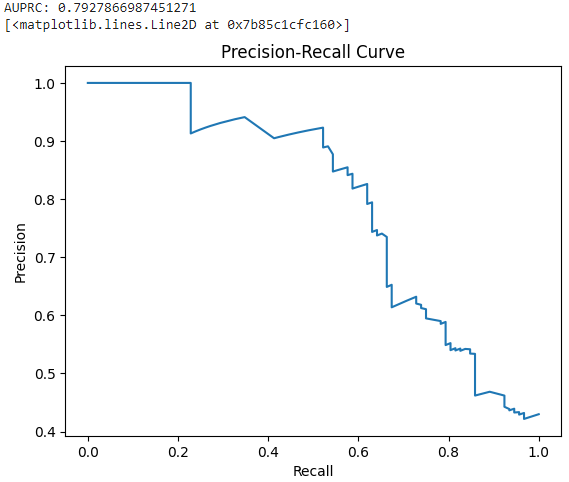


**SVM amb kernel radial**

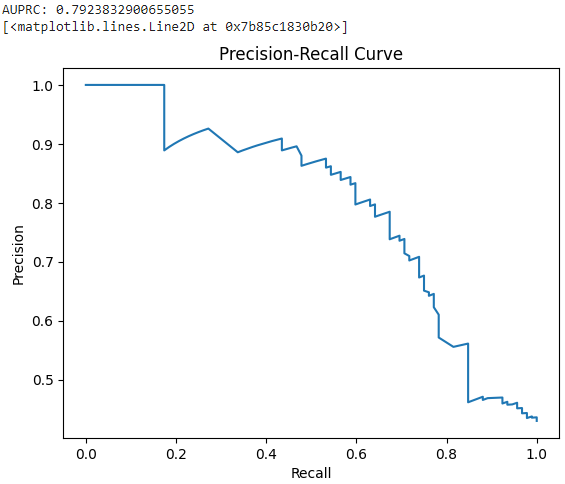

Ambdues corbes comencen amb una precision alta, és a dir, que classifica com que han sobreviscut als que realment ho han fet, però a mida que el recall, que mesura la proporció de casos positius entre els positius reals, augmenta, fa que disminueixi la precisió. Això succeeix perquè com més quantitat de casos es volen classificar, més probabilitat hi ha de que s'equivoqui.

L'àrea sota la corba (AUC) de totes dues és de 0,79. Un valor de 1 indica un rendiment perfecte, així que el que hem obtingut ens diu que el classificador funciona bé.


Podríem millorar els nostres models realitzant més cerques d'hyperparametres, per tal de que siguin el més òptims possible. Igual haver cercat únicament un hyperparametre ha condicionat el rendiment.